# *Outlines*

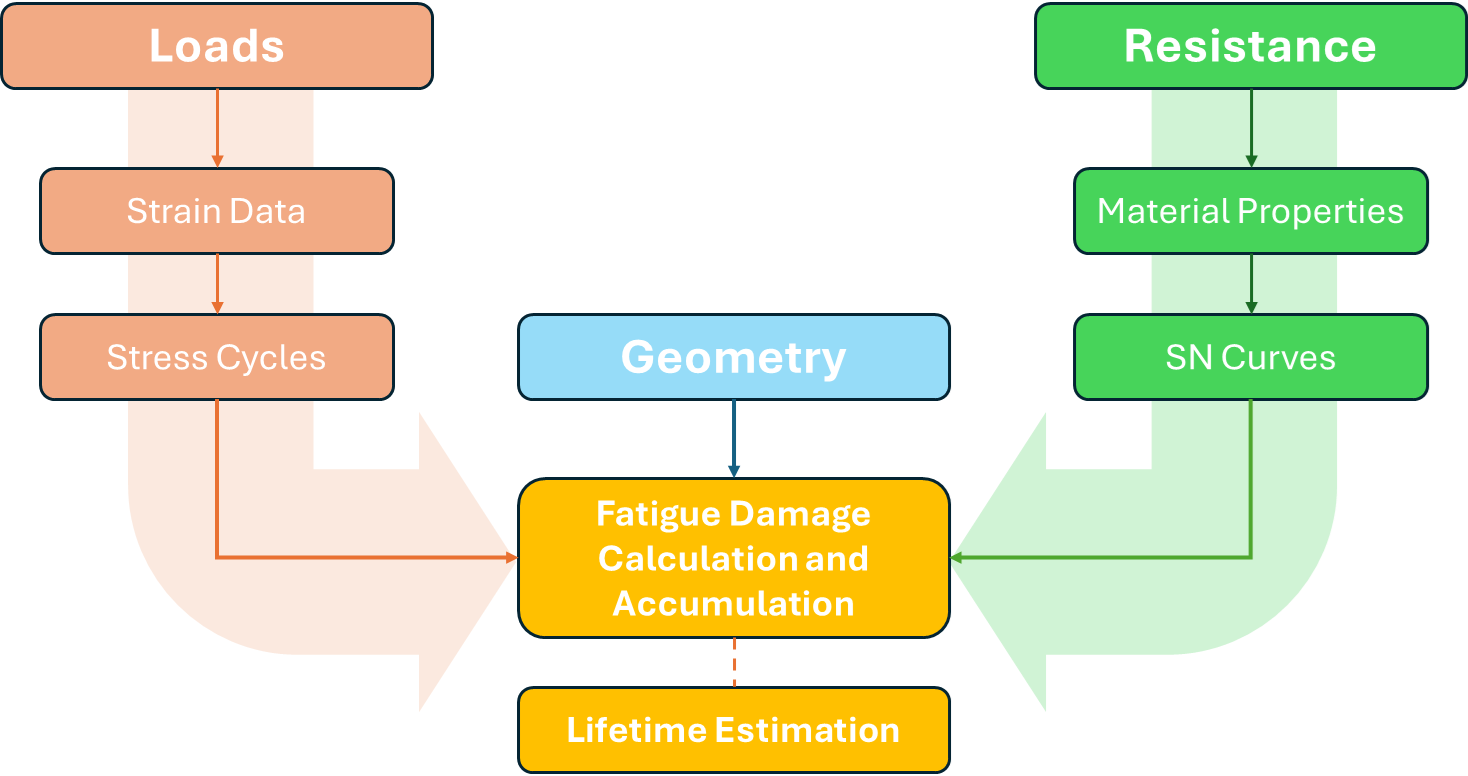


# *Loads*

We will be using loads from [WILLOW Norther Open Source Dataset](https://zenodo.org/records/11093262) for conducting this workshop

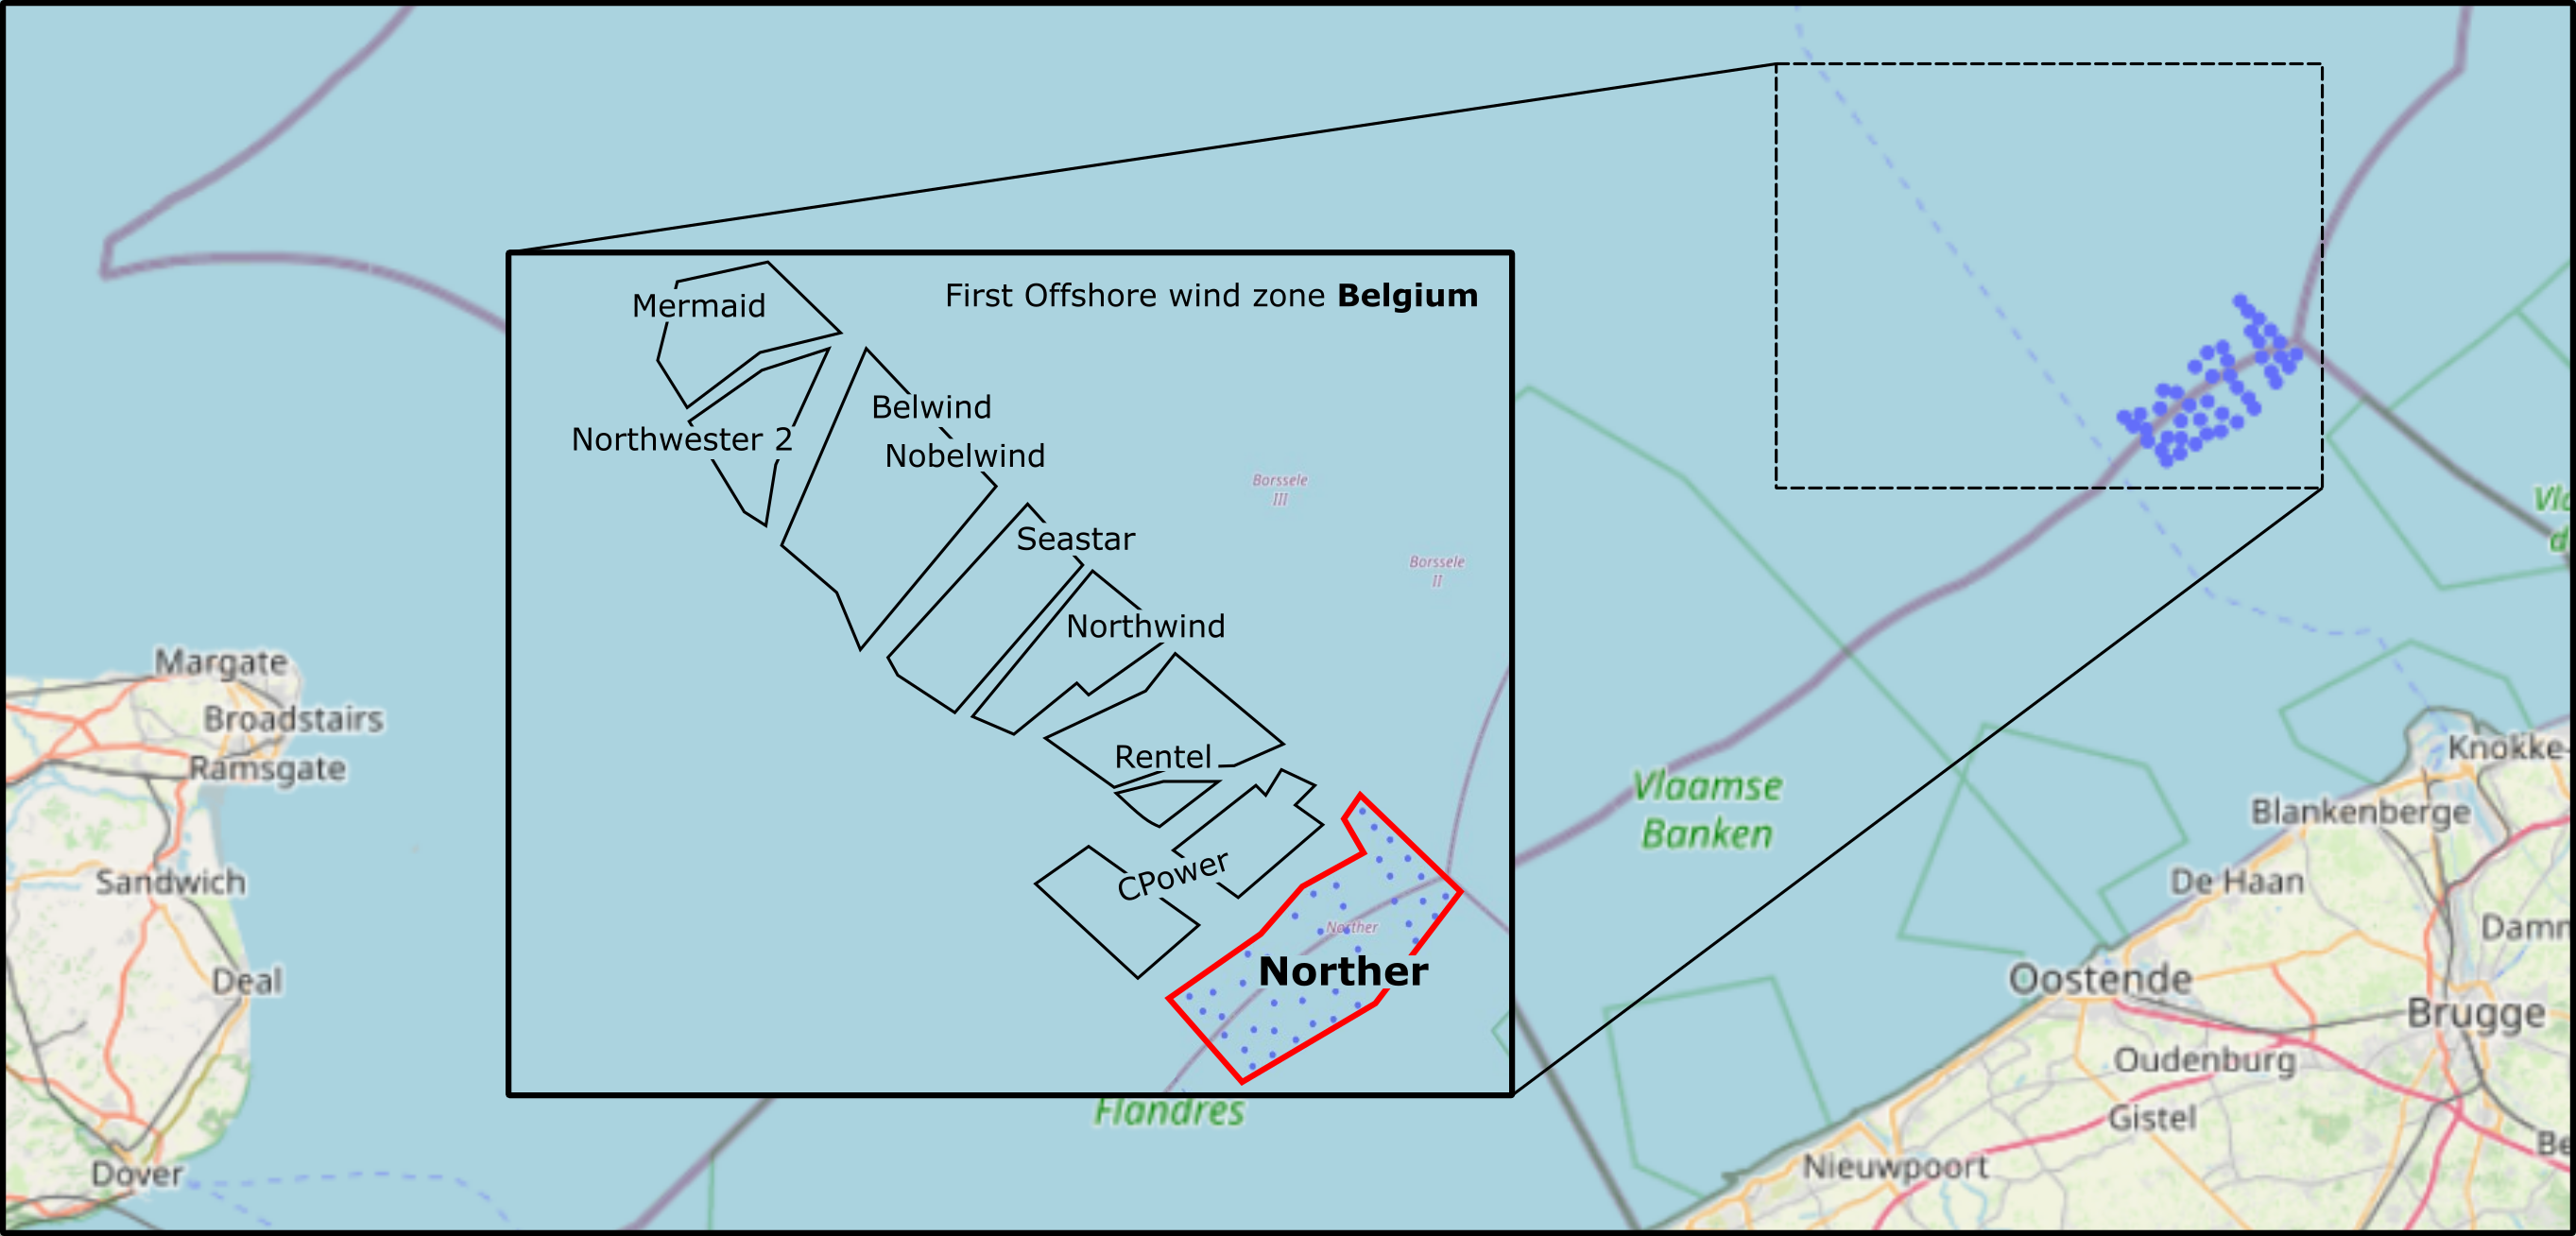



There are various sensors installed on this turbine including accelerometers, strain gauges, fiber bragg gratings (FBGs)
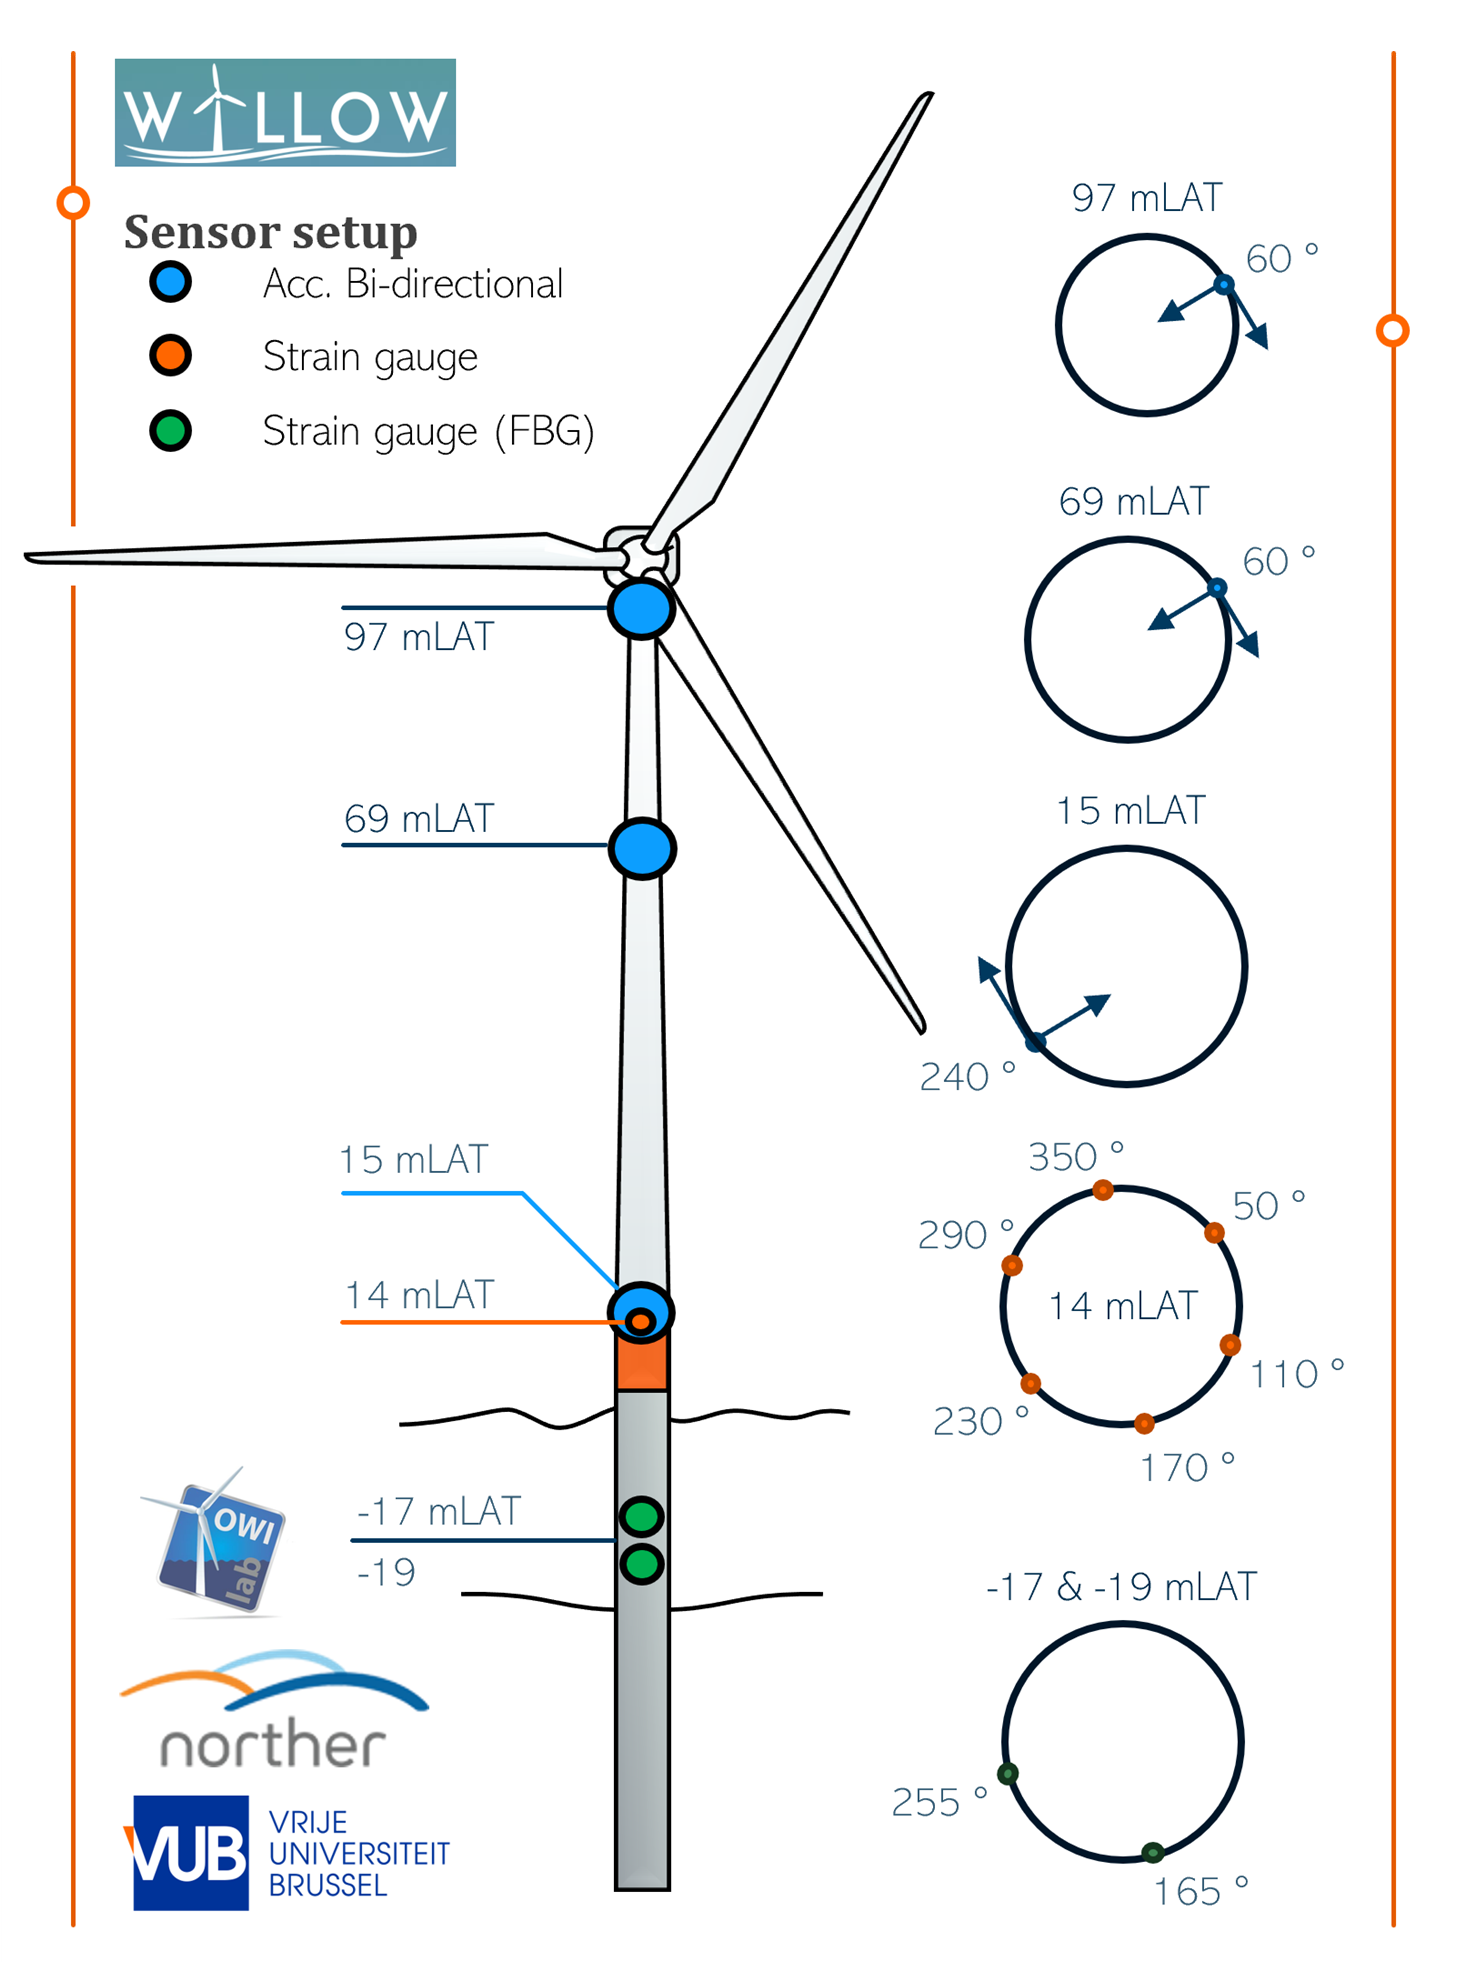

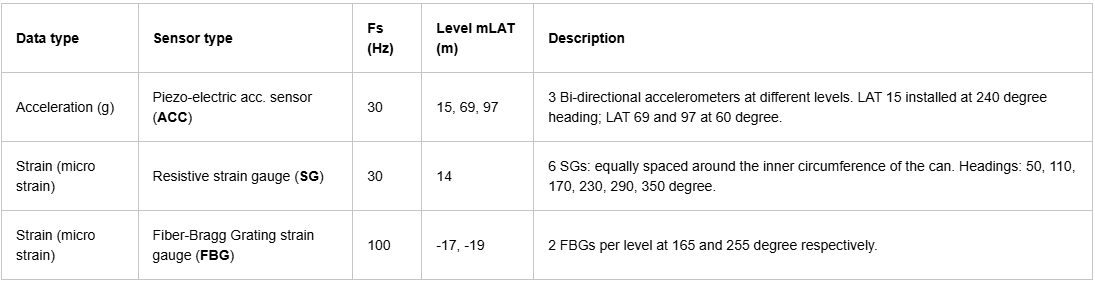


The list of SCADA parameters and the intervals for which the data is avaliable is also given as follows:

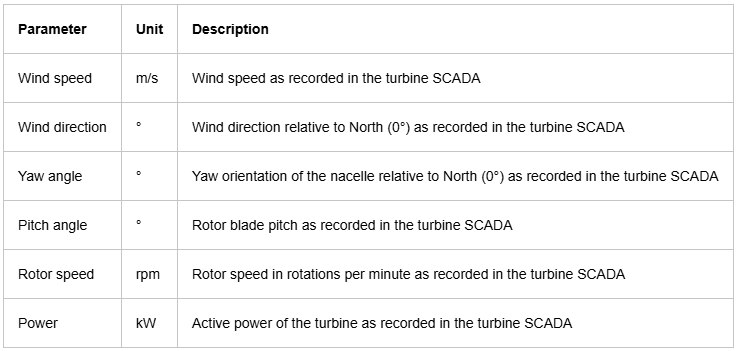


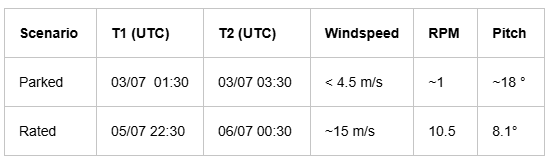


## Loading Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas() 


# codeworkspace in github repo for data--check
# Read Parquet file with Pandas: 
file_path_parked = 'NRT-WTG_Parked.parquet.gz' 
file_path_rated = 'NRT-WTG_Rated.parquet.gz' 
data_parked = pd.read_parquet(file_path_parked) 
data_rated = pd.read_parquet(file_path_rated) 

# Add case_ID column to each dataset
data_parked["case_ID"] = "parked"
data_rated["case_ID"] = "rated"

data_ = pd.concat([data_parked, data_rated]).sort_index()

data_

## Data Pre-processing

In [ ]:
# Drop columns containing '_FBG_' and '_ACC_'
data_ = data_.drop(columns=[col for col in data_.columns if "_FBG_" in col or "_ACC_" in col])

In [ ]:
data_

In [ ]:
# Identify different columns
sg_cols = [c for c in data_.columns if "TP_SG" in c]  # strain gauges channels
SCADA_cols = [c for c in data_.columns if c not in sg_cols]  # SCADA channels

In [ ]:
# Numeric columns only
numeric_SCADA_cols = data_[SCADA_cols].select_dtypes(include='number').columns
SCADA_data = data_[numeric_SCADA_cols]
SCADA_data = SCADA_data.dropna()
# Resample numeric columns for mean and std
SCADA_resampled = (
    SCADA_data
    .resample("10min")
    .agg(["mean", "std"])
)

# Flatten MultiIndex columns
SCADA_resampled.columns = [f"{col}-{stat}" for col, stat in SCADA_resampled.columns]

# Resample case_ID separately, take the first value in each 10-min bin
case_id_resampled = data_["case_ID"].resample("10min").first()

# Combine numeric stats with case_ID
SCADA_resampled["case_ID"] = case_id_resampled

SCADA_resampled.dropna(inplace=True)
SCADA_resampled

In [ ]:
SCADA_resampled.describe()

In [ ]:
E = 210e9  # Pa

stress_df = data_[sg_cols] * 1e-6 * E * 1e-6  # For conversion to MPa

stress_df.columns = [col.replace("[microstrain]", "[MPa]").strip() for col in stress_df.columns]

In [ ]:
stress_df.dropna(inplace=True)

In [ ]:
stress_df

In [ ]:
import plotly.graph_objects as go

sg230 = stress_df['TP_SG_LAT014_DEG230_0_nr1 [MPa]']

# X-axis as minutes
x = np.arange(len(sg230)) / (30*60)   # 30 Hz → samples per second → minutes

# Build interactive plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x,
    y=sg230.values,
    mode="lines",
    line=dict(color="blue", width=1),
    name="Stress Signal"
))

fig.update_layout(
    title="Stress Time Series: TP_SG_LAT014_DEG230_0_nr1",
    xaxis_title="Time [minutes]",
    yaxis_title="Stress [MPa]",
    hovermode="x unified",
    template="plotly_white",
    width=1000,
    height=400
)

fig.show()

## Cycle counting the signals

We need `py_fatigue` for processing the signal into cycle_counts and further calculating fatigue damage

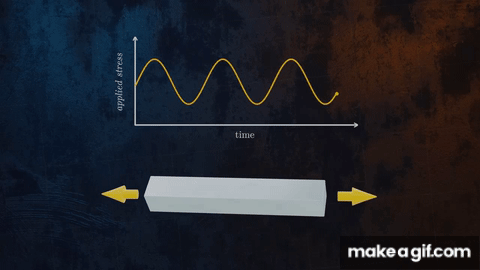

### Py-Fatigue Installing and Importing


`py_fatigue` package can be installed simply running 
`pip install py_fatigue` on the command prompt. If you want to directly install in Jupyter Notebook you can use `!pip install py_fatigue` in a code cell of Jupyter Notebook.


### Dependencies
`py_fatigue` relies on the following PyPi packages
| Package      | Version |
|--------------|---------|
| numpy        | >=1.18,<1.24    |
| plotly       | 5.6     |
| pandas       | 1.4     |
| numba        | >=0.56,<0.57    |
| matplotlib   | 3.5     |
| pydantic     | <3.0.0 |


### *[Rainflow Cycle Counting using py_fatigue](https://owi-lab.github.io/py_fatigue/user/examples/04-cycle_counting.html)*
The data-driven fatigue lifetime analysis starts with the strain signals from strain gauges that is converted to stress-time series signal. The fatigue damage calculation depends on various features of this stress-time signal i.e **stress ranges** and **number of cycles**. Other features such as mean stress also affect the fatigue damage but they are accounted using various corrections such as **DNVGL-RP-C203 mean stress effect correction**, **Walker correction** and **Smith-Watson-Topper**



The stress-time series features for fatigue damage calculation are extracted using *rainflow counting*. The working of `py_fatigue` is shown on stress-time series already imported.

#### *Extracting a short signal*

A short signal is extracted from original signal for ease of visualization and understanding of the cycle counting process. This short signal will help understand the features of stress-time signal saved in the cycle counting object of the signal.

In [ ]:
import py_fatigue as pf
import warnings
warnings.filterwarnings('ignore')


start_time = sg230.index[0]
# Extracting 100 seconds of signal from original strain signal
end_time = start_time + pd.Timedelta(seconds=100)

ss_ = sg230.loc[start_time:end_time]

ts = ss_.index
ss = ss_.values



#### *Rainflow Counting a Random Signal*
Rainflow counting is performed on the timeseries signal as per following algorithm. The original signal is first converted into a reversal series (the points where a signal reverses direction) and then counted as per the below given algorithm called the **three point rainflow counting method**.

In [ ]:
# Find turning points
ind_tp = pf.cycle_count.rainflow.findtp(ss)

# Build Plotly figure
fig = go.Figure()

# Original signal
fig.add_trace(go.Scatter(
    x=ts, y=ss,
    mode='lines',
    name='Stress Signal',
    line=dict(color='blue')
))

# Turning points
fig.add_trace(go.Scatter(
    x=ts[ind_tp], y=ss[ind_tp],
    mode='markers+text',
    name='Turning Points',
    marker=dict(color='red', size=8, symbol="circle"),
    textposition="top center"
))

fig.update_layout(
    title="Interactive Stress Signal with Turning Points",
    xaxis_title="Time",
    yaxis_title="Stress [MPa]",
    hovermode="x unified"
)

fig.show()

In [ ]:
ss[ind_tp] # We see closely spaced reversals at 142.2--> Inspect using the plot


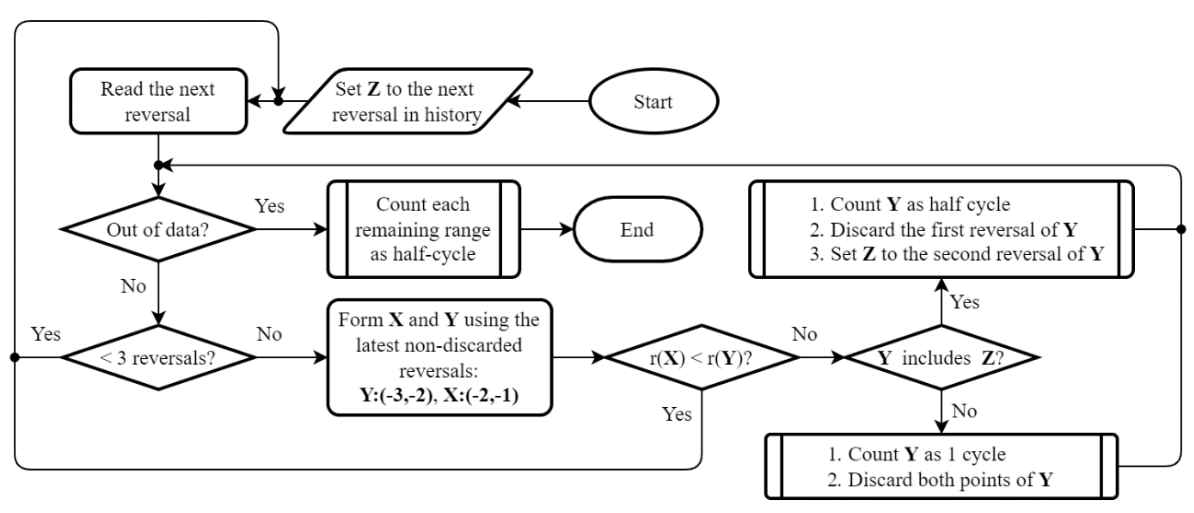


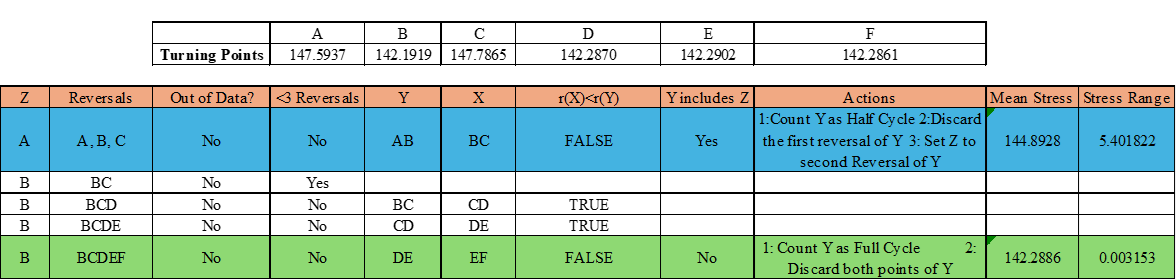


The **Cycle Count Matrix from Timeseries Signal** is generated using `pf.CycleCount`. The timeseries stress signal is fed to `pf.CycleCount.from_timeseries()` method to get a cycle_count matrix. The implementation is shown on the short demo signal generated above.

In [ ]:
# CycleCount definition
cycle_count_test = pf.CycleCount.from_timeseries(
    data=ss, mean_bin_width=3, range_bin_width=3,
)
cycle_count_test

The cycle counting matrix as seen above summarizes the time series signal in the form of number of cycles (completed/ closed cycles) categorized as large and small cycles, number of residuals, number of small cycles etc. Please note that the largest stress range could be from the half cycles. These details will be discussed more in detail in coming sections.

The cycle_count object can be converted into pandas dataframe using `cc.to_df()` method. The dataframe shows the full and half (residual) cycles along with their respective mean stress values and stress ranges without binning.

In [ ]:
cycle_count_test.to_df().head()

The cycle_count instance is usually exported as a dictionary using `cc.as_dict()` method. The dictionary of cc object saves the mean stress, stress range of full and half (residual) cycles. This method bins the data for cycles. The residual signal sequence is also saved in dictionary.

In [ ]:
exp_dict = cycle_count_test.as_dict(max_consecutive_zeros=20, damage_tolerance_for_binning=1)
exp_dict

In [ ]:
# Reconstructing the CycleCount instance from the exported matrix
cycle_count_d = pf.CycleCount.from_rainflow(exp_dict, name="Short Signal")
cycle_count_d

The dictionary of the `cycle_count` object can be exported into `.json` file to be saved on a local hard drive. This `.json` file can be exported back to regenerated `cycle_count` object.

The cycle count instance can be regenerated from the exported dictionary using `CycleCount.from_rainflow()` method.

It is interesting to note that the residual reversals in sequence is also saved in the cycle count object along with the residual cycels and can be plotted to visualize as given below.

In [ ]:
fig = plt.figure(figsize=(10, 4))
cycle_count_test.plot_residuals_sequence(label='Cycle Count Signal', fig=fig)

Now that we have seen the application of `CycleCount` method on a rather simple signal, we will now implement it on a much longer signal to get some reasonable values of damage. Let's use the complete signal to apply `CycleCount` method on it following the same methodology as before

**We can apply cycle counting on complete signal at once but that poses a few practical limitations**

1: cycle counting long signals is time consuming

2: With each second of incoming new signal, we need to reprocess the whole time series and perform cycle counting

3: Industry standard to store results in 10-minute intervals and is adopted for SHM as well.

4: Easier to store/ retrieve 10-minute cycle counts and add them up to regenerate cycle count of whole signal.


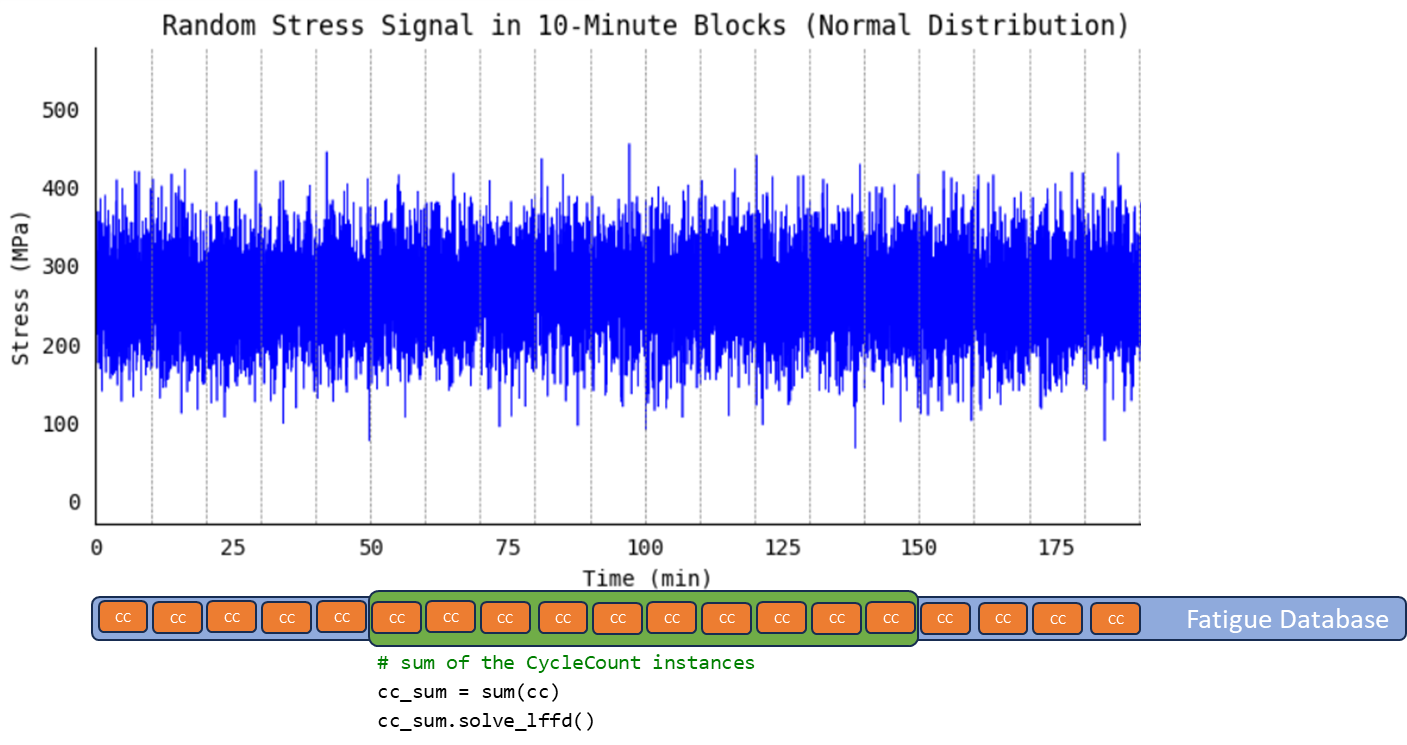



In [ ]:
def count_cycles(block):
    cycle_counts = {}

    if block.empty:
        return {col: None for col in block.columns}  # return None for all columns

    # numeric time in seconds since start of block
    ts = (block.index.view("int64") / 1e9)
#    ts = ts - ts[0]  # optional: start from 0

    block_timestamp = block.index[0].to_pydatetime()  # safe now

    for col in block.columns:
        ss = block[col].values
        if len(ss) == 0 or np.all(np.isnan(ss)):
            cycle_counts[col] = None
            continue
        try:
            clean_name = col.replace("[microstrain]", "").strip()
            cc = pf.CycleCount.from_timeseries(
                data=ss,
                time=ts,
                timestamp=block_timestamp,
                name=clean_name,
                unit="MPa"
            )
            cycle_counts[col] = cc
        except Exception as e:
            cycle_counts[col] = None
    return cycle_counts


In [ ]:
stress_resampled = (
    stress_df
    .groupby(pd.Grouper(freq="10min"))
    .apply(count_cycles)
)
# Convert Series of dicts into DataFrame
stress_resampled = stress_resampled.apply(pd.Series)
stress_resampled.dropna(inplace=True)


In [ ]:
stress_resampled

In [ ]:
data_processed = pd.concat(
    [SCADA_resampled, stress_resampled.add_prefix("CC_")],
    axis=1
)

data_processed

In [ ]:
# Find all columns containing '_DEG230_'
deg230_cols = [col for col in data_processed.columns if "_DEG230_" in col]

# Select only those columns
deg230_data = data_processed[deg230_cols]
deg230_data

## [Low Frequency Fatigue Dynamics](https://wes.copernicus.org/articles/8/1839/2023/)

In [ ]:
#Resolved residuals in cycle counted objects
NR_CC = data_processed['CC_TP_SG_LAT014_DEG230_0_nr1 [MPa]'].sum()
RR_CC = NR_CC.resolve_residuals()
NR_CC

In [ ]:
RR_CC

In [ ]:
fig = plt.figure(figsize=(10, 4))
NR_CC.plot_residuals_sequence(label='Cycle Count Signal', fig = fig)
plt.show()

In [ ]:
ss = stress_df['TP_SG_LAT014_DEG230_0_nr1 [MPa]']
cc = pf.CycleCount.from_timeseries(
    data=ss.values,
    name="From complete signal",
    unit="MPa"
)

cc

In [ ]:

fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))
NR_CC.plot_histogram(fig=fig, ax=axs[0], plot_type="counts-range-2D",
                           marker="d", s=5, edgecolors="#222",linewidth=0.25)
axs[0].set_title("Cycle-count without residuals resolved")
RR_CC.plot_histogram(fig=fig, ax=axs[1], plot_type="counts-range-2D",
                             marker="d", s=5, edgecolors="#222",linewidth=0.25)
axs[1].set_title("Cycle-count with residuals resolved")
plt.show()

**Why Does it matter???**

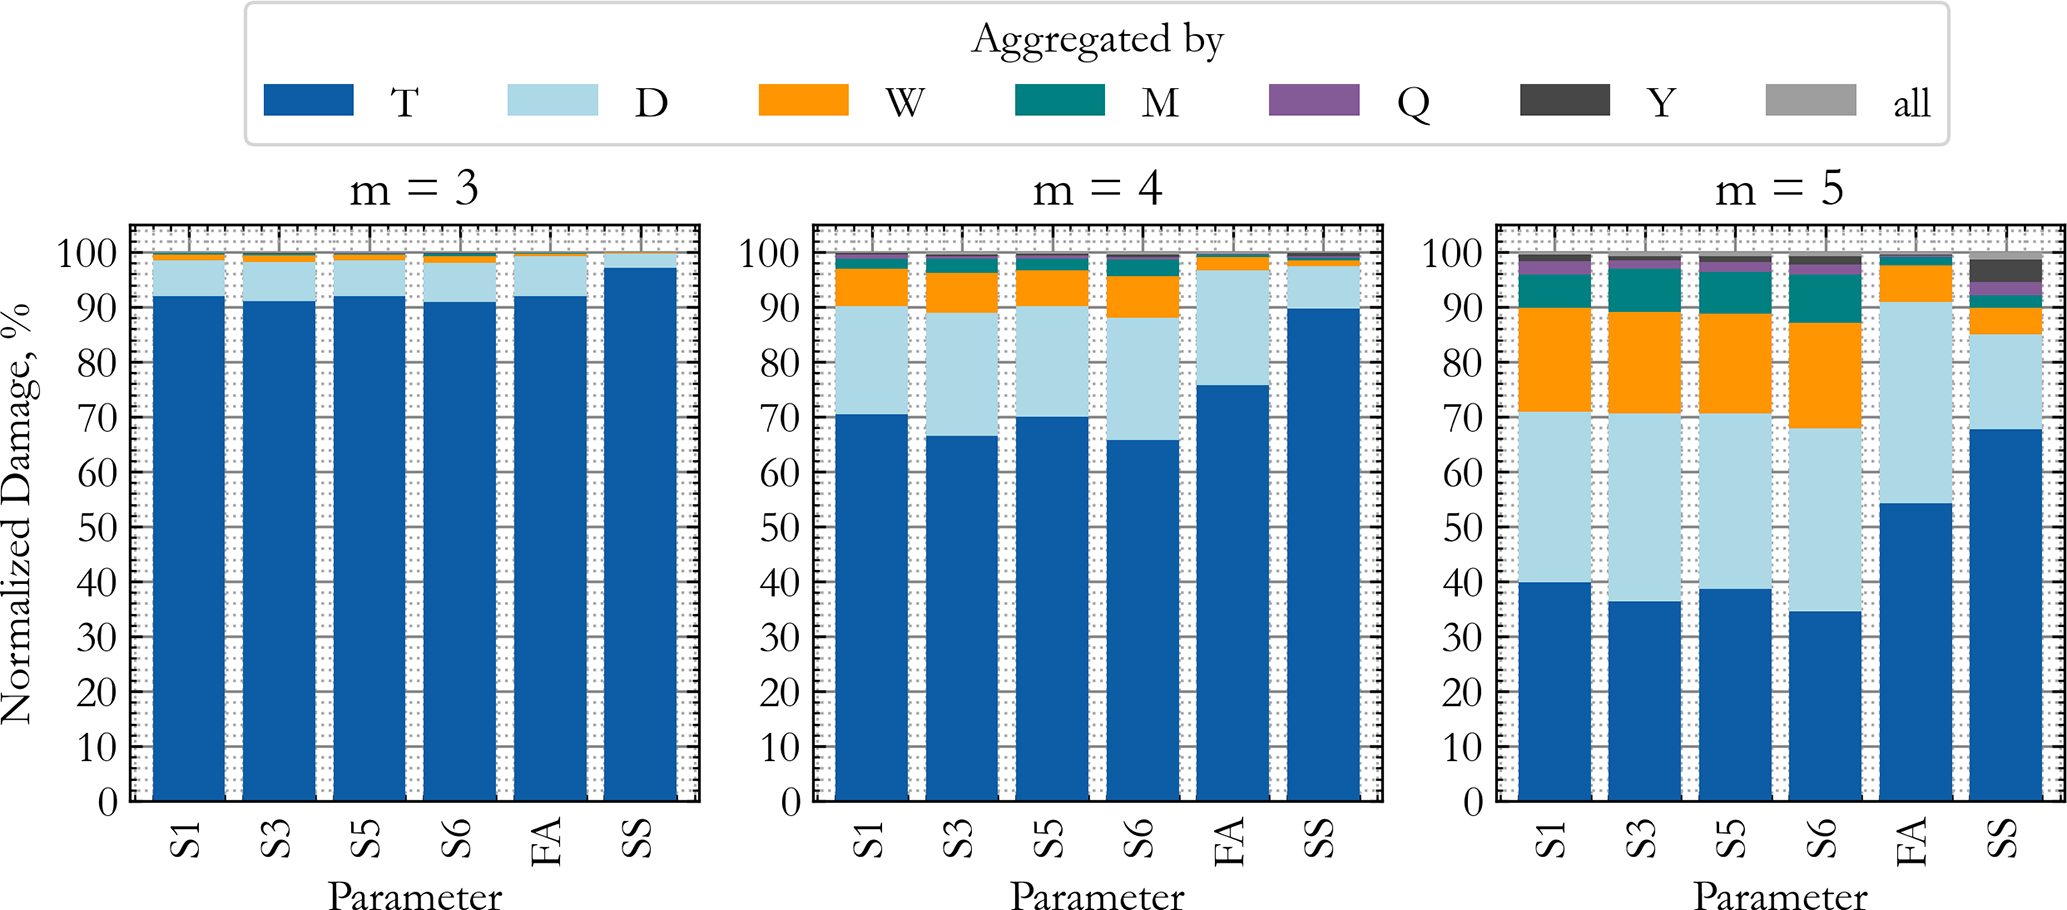

Share of the low-frequency cycles of various lengths in the final LFFD factor of T1 after 3 years. Damages are normalized to 100 %. (Without LFFD: T, daily: D, weekly: W, monthly: M, quarterly: Q, and yearly: Y).


**How can we account for LFFD?**

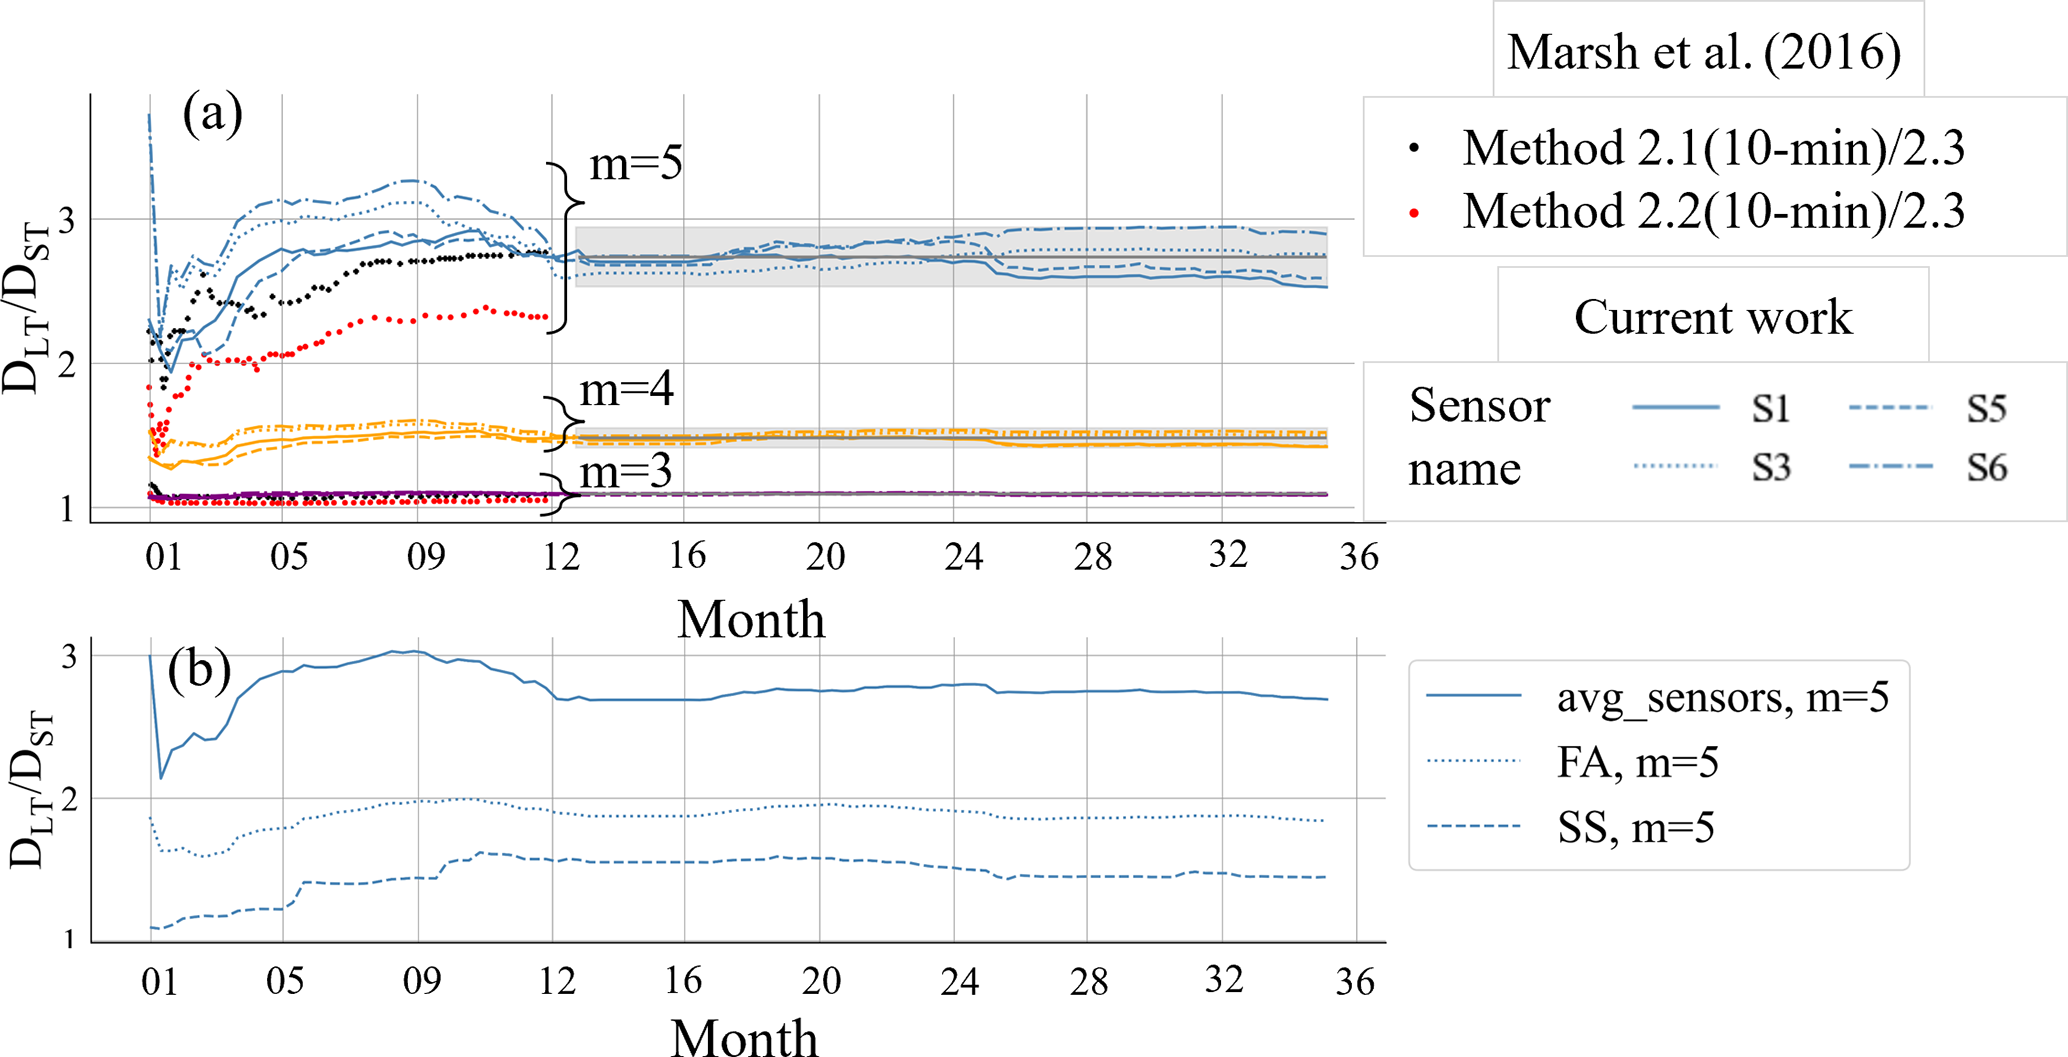

Trend in LFFD factor along the circumference of T1 over time using 3 years of SHM data, plus the results of Marsh et al. (2016). The solid grey line shows the average of the converged values of all sensors, and the grey area is the average ± 2 SDs. (b) Comparison of the LFFD factor value from FA and SS and the average of the sensors for m=5.

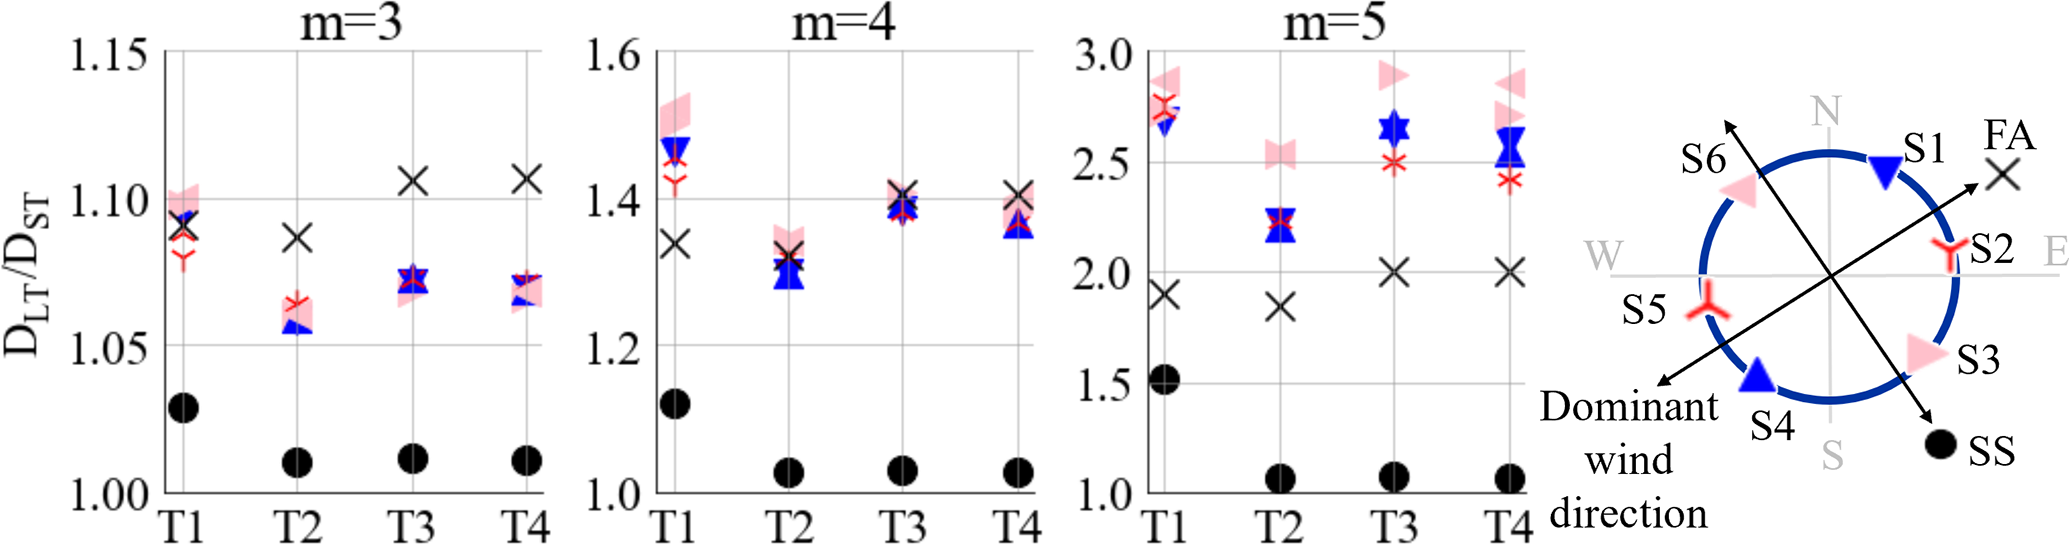

Average of the stabilized LFFD factors after 9 months for the six positions along the circumference and FA and SS, for T1 of Farm 1 and T2, T3, and T4 of Farm 2. Each box is for an SN curve slope

# *Geometry - OWI MetaDataBase*

In [ ]:
#import json
import os
#import requests
import dotenv
from owimetadatabase_preprocessor.locations.io import LocationsAPI
from owimetadatabase_preprocessor.fatigue.io import FatigueAPI
from owimetadatabase_preprocessor.geometry.io import GeometryAPI

In [ ]:
## Credentials for Metadatabase
dotenv.load_dotenv()

api_root = 'https://owimetadatabase-dev.azurewebsites.net/api/v1'
TOKEN = os.getenv('OWIMETA_TOKEN')
head = {'Authorization': 'Token %s' % (TOKEN)}
api_geo = GeometryAPI(api_root=api_root, token=TOKEN)
#api_geo = GeometryAPI(api_root=api_root, uname=user,password=password)

## Geometry APIs

In [ ]:
turbine_ID = 'NRT_demo'

owts = api_geo.get_owt_geometry_processor(turbines = turbine_ID, model_definition = 'as-designed NRT_demo')
owts.process_structures()

In [ ]:
list(owts.__dict__.keys())

In [ ]:
owts.all_turbines

In [ ]:
data, layout = owts.sub_assemblies[turbine_ID]['MP'].plotly()
fig = go.Figure(data=data, layout=layout)
# Set figure size in pixels
fig.update_layout(width=600, height=600)

fig.show()

In [ ]:
owts.monopile

**Check the sensors location to calculate stress extrapolation factor**

## *Static Extrapolation of Loads*
Till now, we have not considered any stress concentration factor in the cycle counting objects. These factors are important for **Stress Transformation to other locations**, **Incorporatethe effect of geometrical irregularities** and **include the effect of welds in the structure**

Consider a cantilever beam with varying cross-section and a point load applied at the tip as shown in Figure 2. The bending moment diagram in the cantilever beam is also shown.

The signal we have been using so far was stress signal measured at Section A-A of the given beam. We now have the measured stresses at Section A-A. From the bending moment diagram we notice that Section A-A is not the most critical location in the beam. At Section B-B, the bending moment is higher and there is a circumferential weld at that section as well. 

The stress signal needs to be transformed to Section B-B for calculation of the accumulated damage at Section B-B. Suppose from design, we know the bending moment diagram for the beam subjected to operation load **F** at the tip. The bending moment ratio at section A-A and section B-B is calculated as the load extrapolation factor shown in `Figure 2`. Similarly, the cross-sectional details at section A-A and section B-B are not the same. Thus, a stress extrapolation factor incorporating the effect of varying radius and second moment of area of the sections is calculated as shown in `Figure 2`. The circumferential weld at section B-B introduces a geometric irregularity and thus is accounted for a stress concentration factor. Finally a materials safety factor as per design is also included in the calculations.

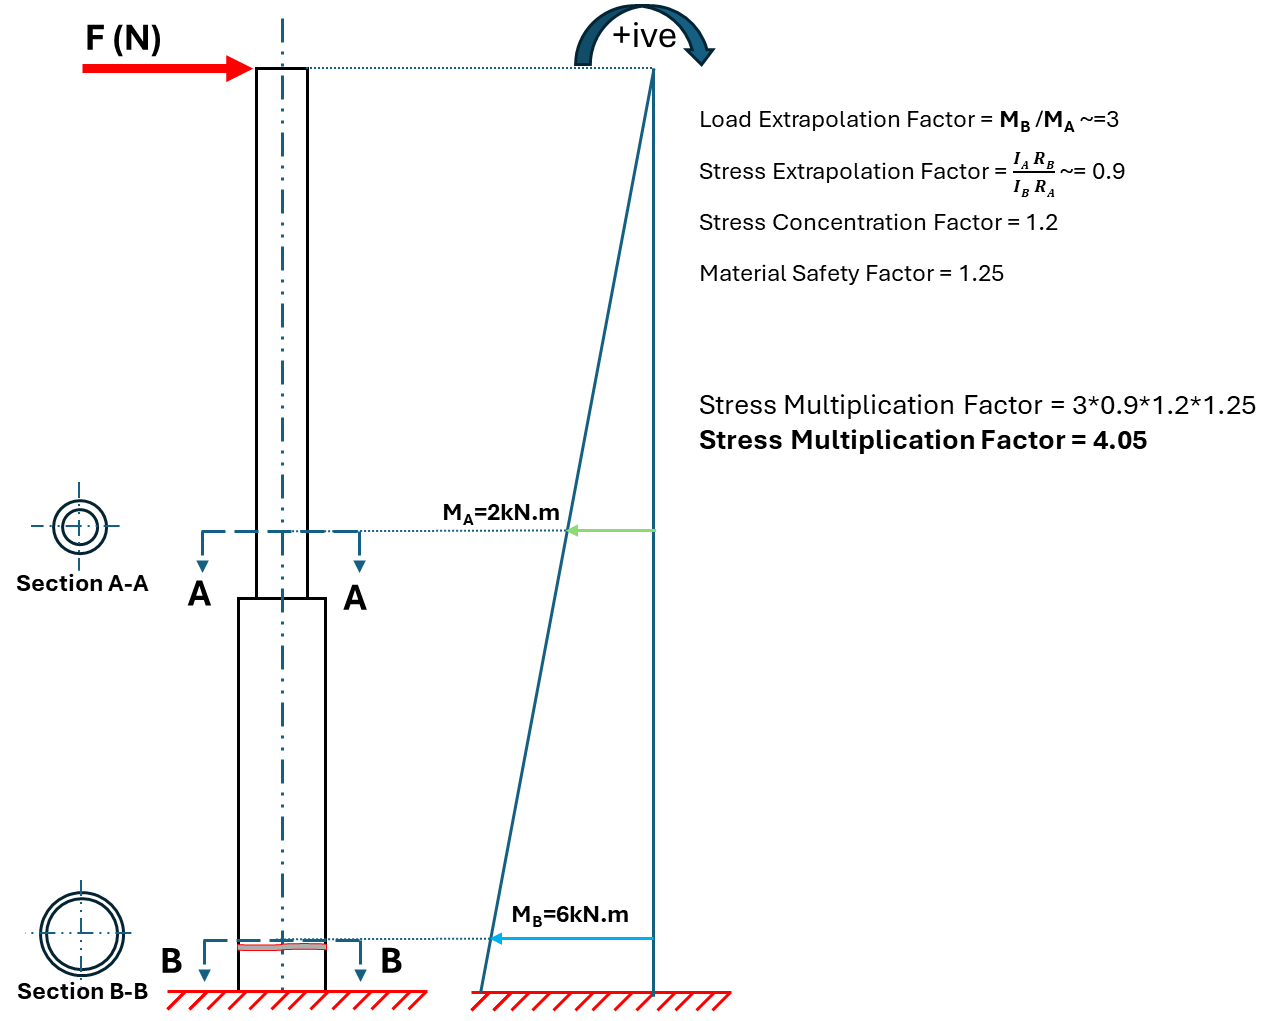

<div align="center"><em>Figure 2: Bending Moment Diagram of a Beam Illustration and Static Extrapolation Factor</em></div>

All these factors are accumulated in a single **Stress Multiplication Factor** which is used for scaling the `cycle_count` objects and thus for accumulated damage calculation at Section B-B.

In [ ]:
RR_CC

In [ ]:
SMF = 4.05 #Stress Multiplication Factor
RR_CC*SMF

In [ ]:
owts.transition_piece

In [ ]:
d_A = owts.transition_piece.at['nrt_demo_tp_03', 'Diameter from [m]']
d_A

In [ ]:
t_A = owts.transition_piece.at['nrt_demo_tp_03', 'Wall thickness [mm]']
t_A

In [ ]:
d_B = owts.monopile.at['nrt_demo_mp_11', 'Diameter from [m]']
d_B

In [ ]:
t_B = owts.monopile.at['nrt_demo_mp_11', 'Wall thickness [mm]']
t_B

In [ ]:
def moment_of_inertia(diameter, thickness):
    """
    Calculate the second moment of area (I) for a hollow circular section.
    
    Parameters
    ----------
    diameter : float
        Outer diameter in meters.
    thickness : float
        Wall thickness in millimeters.
    
    Returns
    -------
    float
        Moment of inertia (m⁴)
    """
    I = (np.pi * (diameter**4 - (diameter - 2 * (thickness / 1000))**4) / 64)
    return I

In [ ]:
I_A = moment_of_inertia(d_A, t_A)
I_B = moment_of_inertia(d_B, t_B)

SEF = (I_A*0.5*d_B)/(I_B*0.5*d_A)
SEF

# *Results - OWI MetaDataBase*

**Demonstration of loading Stress concentration factors for as-built weld geometry from results module for a particular weld.
Plot the resutls and maybe extract the mean or maximum value for demonstration or further analysis**

In [ ]:
# Calculation of SCFs and damage factor for stress scaling

In [ ]:
LEF = 3
material_SF = 1.25
SCF_weld = 1.15
damage_Factor = LEF*SEF*material_SF*SCF_weld
print(damage_Factor)

# *Resistance - OWI MetaDataBase*

## *Fatigue APIs*

In [ ]:
api_fatigue = FatigueAPI(api_root=api_root, token=TOKEN)

In [ ]:
sncurves = api_fatigue.get_sncurves()
sncurve = sncurves[0]
print(f"Total number of accessible SN curves in the database currently is {len(sncurves)}.")

In [ ]:
sncurves

In [ ]:
data, layout = sncurve.plotly()
fig = go.Figure(data=data, layout=layout)


In [ ]:
api_fatigue.get_fatiguesubassembly?

In [ ]:
turbine_ID

In [ ]:
fdsa = api_fatigue.get_fatiguesubassembly(turbine=turbine_ID , subassembly="MP") ##NRTC3turbine_ID
#turbines = turbine_ID, 

In [ ]:
fdsa['MP']

In [ ]:
fig = go.Figure(fdsa['MP'].plotly(showplot=False))
# Set figure size in pixels
fig.update_layout(width=600, height=600)

fig.show()

In [ ]:
fatigue_details = api_fatigue.get_fatiguedetails(title__icontains=turbine_ID + '_MP', modeldefinition__title='as-designed ' + turbine_ID)
fatigue_details

In [ ]:
fatigue_details[20]

In [ ]:
indices = [i for i, entry in enumerate(fatigue_details) if "CW24" in str(entry)]
crit_detail = fatigue_details[indices[0]]
crit_detail

In [ ]:
print(crit_detail.buildingblocktop.title)
print(crit_detail.buildingblock.title)

In [ ]:
crit_detail.sncurves

In [ ]:
sn = crit_detail.sncurves['sncurvein']

In [ ]:
sn_comp = pf.SNCurve(
    slope=sn.m, 
    intercept=sn.log_a, 
    environment = sn.environment, 
    curve = sn.curve, 
    norm = sn.norm,
    color='g'
)

In [ ]:
sn_comp

# *Fatigue Damage Calculation*

In [ ]:
LEF = 3
scale_f = crit_detail.scaleeffect
SCF_in = crit_detail.scfin
material_SF = 1.25
damage_Factor = LEF*SEF*SCF_in*scale_f*material_SF
print(damage_Factor)

In [ ]:
cc

In [ ]:
scaled_cc = cc*damage_Factor
scaled_cc

In [ ]:
fat_dmg = pf.damage.stress_life.get_pm(scaled_cc, sn_comp)

In [ ]:
fat_dmg.sum()

In [ ]:
# Find all columns containing '_DEG230_'
deg230_cols = [col for col in data_processed.columns if "_DEG230_" in col]

# Select only those columns
deg230_data = data_processed[deg230_cols]

for col in deg230_data.columns:
    damage_col = col + " Damage"
    deg230_data[damage_col] = deg230_data[col].progress_apply(
        lambda cc: (
            sum(pf.damage.stress_life.get_pm(cc * damage_Factor, sn_comp))
            if cc is not None and not isinstance(cc, float) else np.nan
        )
    )


In [ ]:
# IEC 61400 cyclecount plot with cumulative cycles vs stress
# Fatigue spectra cycles vs stress on a SN Curve plot! comparison of fatigue spectra for different operational conditions
# Link with the defects! fatigue life beyond welds!
# approaches to fatigue life--stress life (assumption on undetectable cracks) and crack growth curve (visible crack with known params) needs paris law!
## changing the ratio of operating conditions affects the lifetime!

In [ ]:
# Add case_ID column (take directly from data_processed)
deg230_data["case_ID"] = data_processed.loc[deg230_data.index, "case_ID"].values
deg230_data

In [ ]:
damage_cols = [c for c in deg230_data.columns if "Damage" in c]


# Synthetic timeline
n_steps = len(deg230_data)
new_index = pd.date_range(start="2020-07-03 01:30:00+00:00", periods=n_steps, freq="10min")
deg230_data = deg230_data.set_index(new_index)
deg230_data['cumulative damage'] = deg230_data[damage_cols].cumsum()

plt.figure(figsize=(10, 6))
for col in damage_cols:
    plt.plot(deg230_data.index, deg230_data['cumulative damage'], label=col, marker='o',      linestyle='-' )


# # Plot each column with marker style based on case_ID
# for col in damage_cols:
#     for case_id, marker in case_markers.items():
#         mask = deg230_data["case_ID"] == case_id
#         plt.plot(
#             deg230_data.index[mask],
#             deg230_data.loc[mask, 'cumulative damage'],
#             label=f"{col} ({case_id})",
#             marker=marker,
#             linestyle="-"
#         )


# Show ticks for every 10-min interval
plt.xticks(deg230_data.index, rotation=45)

plt.xlabel("Time (10-min intervals)")
plt.ylabel("Cumulative Fatigue Damage")
plt.title("Cumulative Fatigue Damage at 230 Degrees Heading")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




In [ ]:
OS_dmg_mean = deg230_data.groupby('case_ID')['CC_TP_SG_LAT014_DEG230_0_nr1 [MPa] Damage'].mean()
OS_dmg_mean

In [ ]:
## Spatial extrapolation x
## Residuals-- a short description instead of deep dive!
## Industrial relevance-- instead of research focus!

## **Fatigue Lifetime Estimation**

fatigue life can be estimated as the inverse of Yearly fatige damage

In [ ]:
1/(365*24*6*OS_dmg_mean['rated'])

In [ ]:
1/(365*24*6*OS_dmg_mean['parked'])

We can assume proportions of operational conditions for further analysis, we can play with these two operational states to see their effects on the lifetime

In [ ]:
prob_parked = 0.1
prob_rated = 1-prob_parked

In [ ]:
yearly_damage = prob_rated*(365*24*6*OS_dmg_mean['rated']) + prob_parked*(365*24*6*OS_dmg_mean['parked'])
1/yearly_damage

OWI first >> then loads!
Demo defects in owi metadatabase then the analysis on a simple weld!

# *Defects - OWI MetaDataBase*

**Pulling a demo defect - maybe paint and crack defect? (must have) and combine it with loading for a lifetime analysis (Optional depends on the time)**